In [52]:
# Install/Import Libs & Packages

In [119]:
#install all the libraries
!pip install bs4
!pip install uszipcode
!pip install tqdm
!pip install folium
!pip install geopy


#import all the libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests
import random
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium
from folium.plugins import MiniMap
from geopy.geocoders import Nominatim
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn import metrics
from PIL import Image
import matplotlib.patches as mpatches
import types
from botocore.client import Config
import ibm_boto3
from bs4 import BeautifulSoup
from uszipcode import SearchEngine
import geopy
from geopy.extra.rate_limiter import RateLimiter
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

print('Libraries imported')

Libraries imported


In [54]:
## Download Toronto Data
#Toronto Geographical Data on Neighbhorhoods/Boroughs
Tor_url='https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'
Tor_df = pd.read_html(Tor_url)
Tor_df_postcodes=Tor_df[0]
#print('imported dataframe has', Tor_df_postcodes['Postcode'].count(), "postcodes entries")
#Tor_df_postcodes.head(10)
#df_postcodes.dtypes


In [55]:
#View & Format Toronto Data
Tor_df_postcodes = Tor_df_postcodes[Tor_df_postcodes["Borough"] != "Not assigned"]

#Replace the N/A values of Neighborhood with the Borough Value
Tor_df_postcodes["Neighbourhood"].replace("Not assigned", Tor_df_postcodes["Borough"], inplace=True)

Tor_df_postcodes.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Postcode           Borough     Neighbourhood
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront
5      M6A        North York  Lawrence Heights
6      M6A        North York    Lawrence Manor

In [56]:
#View & Format Toronto Data
#Now combine all the neighbourhoods with the same postal codes
Tor_df = Tor_df_postcodes.groupby(["Postcode","Borough"])["Neighbourhood"].apply(list)
Tor_df = Tor_df.sample(frac=1).reset_index()
Tor_df["Neighbourhood"] = Tor_df["Neighbourhood"].str.join(', ')
Tor_df.head(10)


Postcode           Borough  \
0       M6N              York   
1       M5P   Central Toronto   
2       M7A  Downtown Toronto   
..      ...               ...   
7       M8Y         Etobicoke   
8       M5J  Downtown Toronto   
9       M4V   Central Toronto   

                                        Neighbourhood  
0                       The Junction North, Runnymede  
1                 Forest Hill North, Forest Hill West  
2                                        Queen's Park  
..                                                ...  
7   Humber Bay, King's Mill Park, Kingsway Park So...  
8   Harbourfront East, Toronto Islands, Union Station  
9   Deer Park, Forest Hill SE, Rathnelly, South Hi...  

[10 rows x 3 columns]

In [57]:
#View & Format Toronto Data
#Get the Latitude and Langitude to match the Postcode
!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data
geo = pd.read_csv("Geospatial_Coordinates.csv", index_col = 0)         
Tor_df = Tor_df.join(geo, on = "Postcode")

#Take only those neighborhoods that contain the word Toronto
Tor_df = Tor_df[Tor_df['Borough'].str.contains('Toronto')].reset_index(drop=True)
Tor_df.head()

Postcode           Borough  \
0      M5P   Central Toronto   
1      M7A  Downtown Toronto   
2      M5W  Downtown Toronto   
3      M7Y      East Toronto   
4      M5J  Downtown Toronto   

                                       Neighbourhood   Latitude  Longitude  
0                Forest Hill North, Forest Hill West  43.696948 -79.411307  
1                                       Queen's Park  43.662301 -79.389494  
2                    Stn A PO Boxes 25 The Esplanade  43.646435 -79.374846  
3  Business Reply Mail Processing Centre 969 Eastern  43.662744 -79.321558  
4  Harbourfront East, Toronto Islands, Union Station  43.640816 -79.381752

In [58]:
#check to see that there are 38 neighborhoods 
print("\n{} neighborhoods found in the city of Toronto.".format(Tor_df.shape[0]))


39 neighborhoods found in the city of Toronto.


In [59]:
## Download NYC Data
# Download and explore the new York City dataset
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [60]:
import json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
#Take a look at the data
#newyork_data

#the relevant data is in the features key, which is basically a list of neighborhoods
NY_data = newyork_data['features']
NY_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [61]:
#View & Format NYC Data
# Transform the NY Data into a Pandas dataframe
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NYdf = pd.DataFrame(columns=column_names)

# Make sure the columns are correct
NYdf

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

In [62]:
# Then let's loop through the data and fill the dataframe one row at a time
for data in NY_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NYdf = NYdf.append({'Borough': borough,
                        'Neighborhood': neighborhood_name,
                        'Latitude': neighborhood_lat,
                        'Longitude': neighborhood_lon}, ignore_index=True)
#Take only the neighborhoods from Manhattan
NYdf =NYdf[NYdf['Borough'] == 'Manhattan'].reset_index(drop=True)
NYdf.head(10)


Borough        Neighborhood   Latitude  Longitude
0   Manhattan         Marble Hill  40.876551 -73.910660
1   Manhattan           Chinatown  40.715618 -73.994279
2   Manhattan  Washington Heights  40.851903 -73.936900
..        ...                 ...        ...        ...
7   Manhattan         East Harlem  40.792249 -73.944182
8   Manhattan     Upper East Side  40.775639 -73.960508
9   Manhattan           Yorkville  40.775930 -73.947118

[10 rows x 4 columns]

In [63]:
from geopy.geocoders import Nominatim

NYaddress = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
NYlocation = geolocator.geocode(NYaddress)
NYlatitude = NYlocation.latitude
NYlongitude = NYlocation.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(NYlatitude, NYlongitude))

Toraddress = 'Toronto'
geolocator = Nominatim(user_agent="Toronto_explorer")
Tlocation = geolocator.geocode(Toraddress)
Tlatitude = Tlocation.latitude
Tlongitude = Tlocation.longitude
print('The geographical coordinate of Toronto are {}, {}.'.format(Tlatitude,Tlongitude))

centerLatitude = (NYlatitude + Tlatitude)/2
centerLongitude = (NYlongitude + Tlongitude)/2

print('\nThe geographical central coordinates are {}, {}.'.format(centerLatitude, centerLongitude))

The geograpical coordinate of New York City are 40.7896239, -73.9598939.
The geographical coordinate of Toronto are 43.6534817, -79.3839347.

The geographical central coordinates are 42.2215528, -76.6719143.


In [64]:
tmp = Tor_df.drop("Postcode",axis = 1)
tmp.rename(columns = {"Neighbourhood":"Neighborhood"}, inplace = True)
TorNY_df = NYdf.append(tmp, True).reset_index(drop = True)
pd.set_option('max_rows', 6)
TorNY_df

Borough                         Neighborhood   Latitude  Longitude
0         Manhattan                          Marble Hill  40.876551 -73.910660
1         Manhattan                            Chinatown  40.715618 -73.994279
2         Manhattan                   Washington Heights  40.851903 -73.936900
..              ...                                  ...        ...        ...
76  Central Toronto  The Annex, North Midtown, Yorkville  43.672710 -79.405678
77     East Toronto                      Studio District  43.659526 -79.340923
78     West Toronto         Dovercourt Village, Dufferin  43.669005 -79.442259

[79 rows x 4 columns]

In [65]:
import folium

map_tony = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(TorNY_df['Latitude'], TorNY_df['Longitude'], TorNY_df['Borough'], TorNY_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)
map_tony

In [66]:
map_tony = folium.Map(location=[NYlatitude, NYlongitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(TorNY_df['Latitude'], TorNY_df['Longitude'], TorNY_df['Borough'], TorNY_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (NYlatitude, NYlongitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (Tlatitude, Tlongitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

In [68]:
#Toronto

map_tony = folium.Map(location=[Tlatitude, Tlongitude], zoom_start=11, width='100%', height='100%')

for lat, lng, borough, neighborhood in zip(TorNY_df['Latitude'], TorNY_df['Longitude'], TorNY_df['Borough'], TorNY_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_tony)

minimap = MiniMap(position = 'topleft', center_fixed = (NYlatitude, NYlongitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)

minimap = MiniMap(position='bottomright',  center_fixed = (Tlatitude, Tlongitude), zoom_level_fixed = 8)
minimap.add_to(map_tony)
map_tony

In [70]:
# The code was removed by Watson Studio for sharing.

CMPLNT_NUM  ADDR_PCT_CD   BORO_NM CMPLNT_FR_DT    YEAR  Unnamed: 5  \
0   466502077           75  BROOKLYN   2020-03-30  2020.0         NaN   
1   303191835           77  BROOKLYN   2020-03-28  2020.0         NaN   
2   735488557           43     BRONX   2020-03-29  2020.0         NaN   
3   315962428           40     BRONX   2020-03-29  2020.0         NaN   
4   165437868          114    QUEENS   2020-03-27  2020.0         NaN   

   Unnamed: 6 CMPLNT_FR_TM CMPLNT_TO_DT CMPLNT_TO_TM  ... SUSP_SEX  \
0         NaN     17:30:00    3/31/2020      6:53:00  ...      NaN   
1         NaN     19:30:00    3/28/2020     20:30:00  ...        M   
2         NaN     14:10:00          NaN          NaN  ...      NaN   
3         NaN      7:10:00    3/29/2020      7:16:00  ...        M   
4         NaN     13:15:00    3/27/2020     14:00:00  ...      NaN   

  TRANSIT_DISTRICT  VIC_AGE_GROUP        VIC_RACE VIC_SEX  X_COORD_CD  \
0              NaN          25-44           BLACK       M     1018496   
1              NaN            <18         UNKNOWN       F     1003606   
2              NaN        UNKNOWN         UNKNOWN       D     1019853   
3              NaN          25-44  WHITE HISPANIC       F     1007236   
4              NaN          45-64           BLACK       F     1002018   

  Y_COORD_CD   Latitude  Longitude                                   Lat_Lon  
0     178657  40.656991 -73.876574   (40.65699087900003, -73.87657444799999)  
1     185050  40.674583 -73.930222   (40.67458330800008, -73.93022154099998)  
2     241853  40.830443 -73.871349        (40.83044253800006, -73.871349147)  
3     237260  40.817878 -73.916957  (40.817877907000025, -73.91695668199996)  
4     213258  40.752011 -73.935872   (40.75201086000004, -73.93587196099996)  

[5 rows x 38 columns]

In [71]:
#Loading Crime Data
#NYC
NYCrime.columns


Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'YEAR',
       'Unnamed: 5', 'Unnamed: 6', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT', 'HOUSING_PSA',
       'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
       'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
       'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude',
       'Longitude', 'Lat_Lon'],
      dtype='object')

In [72]:
# Clean the NYCrime Data
#Drop columns that are not needed

NYCrime.drop(['CMPLNT_NUM','YEAR', 'Unnamed: 5', 'Unnamed: 6', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
       'LOC_OF_OCCUR_DESC', 'RPT_DT', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
       'PD_DESC', 'PREM_TYP_DESC','KY_CD', 'PD_CD', 'PD_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'PARKS_NM',
       'HADEVELOPT', 'STATION_NAME', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD'
             ], axis=1, inplace=True)

#Rename columns names for consistency across all dataframes

NYCrime.rename(columns ={'ADDR_PCT_CD' : 'Precinct Number',
                         'CMPLNT_FR_DT': 'Occurrence Year', 
                         'OFNS_DESC' : 'MCI', 
                         'BORO_NM' : 'Borough',
                         'Latitude' : 'Lat', 
                         'Longitude' : 'Long', 
                         'Lat_Lon' : 'Coordinates'}, inplace=True)
NYCrime['Occurrence Year'] = pd.to_datetime(NYCrime['Occurrence Year'], format='%Y-%m-%d') #%Y-%m-%d  #%m/%d/%Y

NYCrime['Occurrence Year'] = NYCrime['Occurrence Year'].dt.year 
NYCrime = NYCrime[NYCrime['Occurrence Year'] == 2019].reset_index(drop=True)
NYCrime.head(5)

Precinct Number    Borough  Occurrence Year              MCI        Lat  \
0                5  MANHATTAN             2019       SEX CRIMES  40.716196   
1               81   BROOKLYN             2019             RAPE  40.689616   
2               83   BROOKLYN             2019  DANGEROUS DRUGS  40.690655   
3               40      BRONX             2019    PETIT LARCENY  40.813805   
4               43      BRONX             2019      THEFT-FRAUD  40.815733   

        Long                               Coordinates  
0 -73.997491  (40.716195914000025, -73.99749074599998)  
1 -73.924393  (40.689615497000034, -73.92439311199998)  
2 -73.908043   (40.69065484200007, -73.90804256199993)  
3 -73.929653   (40.81380495100007, -73.92965290199999)  
4 -73.848350  (40.815733075000026, -73.84835004699994)

In [73]:
# Find out the percentage of types of crime in 2019
#calculate the number of occurrences of each MCI
NYCrimePer = pd.DataFrame(NYCrime['MCI'].value_counts().astype(float))
NYCrimePer = NYCrimePer.reset_index()
NYCrimePer.columns = ['MCI', 'Number of Occurrence'] 

#convert to percentages of the total crimes that occurred in 2019
NYCrimePer['Percentage of Occurrence'] = 100*NYCrimePer['Number of Occurrence']/NYCrimePer['Number of Occurrence'].sum()
NYCrimePer.head(5)

MCI  Number of Occurrence  \
0                   PETIT LARCENY                1171.0   
1                   GRAND LARCENY                1104.0   
2                   HARRASSMENT 2                 512.0   
3  CRIMINAL MISCHIEF & RELATED OF                 466.0   
4   OFF. AGNST PUB ORD SENSBLTY &                 339.0   

   Percentage of Occurrence  
0                 22.813170  
1                 21.507890  
2                  9.974674  
3                  9.078512  
4                  6.604325

In [74]:
NYCrimePer.tail(5)

MCI  Number of Occurrence  \
31            ANTICIPATORY OFFENSES                   3.0   
32   INTOXICATED & IMPAIRED DRIVING                   3.0   
33         OFFENSES INVOLVING FRAUD                   2.0   
34  PROSTITUTION & RELATED OFFENSES                   2.0   
35             FRAUDULENT ACCOSTING                   2.0   

    Percentage of Occurrence  
31                  0.058445  
32                  0.058445  
33                  0.038964  
34                  0.038964  
35                  0.038964

In [75]:
#TO Crime Data

#Import and explore the Crime Data
#Import Homicide Data and MCI data  Toronto as separate dataframes... Will combine into a main dataframe later after cleaning
#the MCI Data does not include homicide data, which is why we need to compbine.
 
body = client_e073509e2b4e4fd9ab9d353e029fb9c7.get_object(Bucket='courseraibmcapstone-donotdelete-pr-iibp9ibtexxq7g',Key='Homicide.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
  
# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
TCrime_Homicidedf = pd.read_csv(body)
TCrime_Homicidedf.head()

X          Y  Index_ Event_Unique_ID  Occurrence_year Division  \
0 -79.386620  43.648640     201         1787320             2006      D52   
1 -79.304939  43.715988     202         1470621             2006      D54   
2 -79.304939  43.715988     203         1470621             2006      D54   
3 -79.228691  43.809391     204         1448992             2006      D42   
4 -79.484482  43.649334     205         1945800             2006      D11   

  Homicide_Type           Occurrence_Date  Hood_ID  \
0      Shooting  2006-10-27T04:00:00.000Z       77   
1      Stabbing  2006-11-05T05:00:00.000Z       43   
2      Stabbing  2006-11-05T05:00:00.000Z       43   
3      Shooting  2006-11-14T05:00:00.000Z      132   
4         Other  2006-11-25T05:00:00.000Z       87   

                            Neighbourhood        Lat       Long  ObjectId  
0  Waterfront Communities-The Island (77)  43.648640 -79.386620         1  
1                   Victoria Village (43)  43.715988 -79.304939         2  
2                   Victoria Village (43)  43.715988 -79.304939         3  
3                           Malvern (132)  43.809391 -79.228691         4  
4                  High Park-Swansea (87)  43.649334 -79.484482         5

In [76]:
# Clean the Homicide Data
#Drop columns that are not needed

TCrime_Homicidedf.drop(['X', 'Y', 'Index_', 'Event_Unique_ID','Division', 'Occurrence_Date', 'Hood_ID', 'ObjectId',], axis = 1, inplace = True)

#rename columns for consistency
TCrime_Homicidedf.rename(columns={'Occurrence_year': 'Occurrence Year'})

#Change the Homicide_Type to MCI and change all the values to Homicide
TCrime_Homicidedf.rename(columns={'Occurrence_year': 'Occurrence Year','Homicide_Type': 'MCI'}, inplace = True)

TCrime_Homicidedf['MCI']= 'Homicide'

TCrime_Homicidedf.head(10)
#TCrime_Homicidedf.shape
#Isolate to the year 2019
TCrime_Homicidedf = TCrime_Homicidedf[TCrime_Homicidedf['Occurrence Year']==2019]

TCrime_Homicidedf.head(5)

Occurrence Year       MCI              Neighbourhood        Lat  \
1015             2019  Homicide         Kennedy Park (124)  43.727463   
1016             2019  Homicide        Rexdale-Kipling (4)  43.722855   
1017             2019  Homicide  Clairlea-Birchmount (120)  43.710480   
1018             2019  Homicide          Dorset Park (126)  43.769581   
1019             2019  Homicide    Rockcliffe-Smythe (111)  43.670605   

           Long  
1015 -79.252602  
1016 -79.559936  
1017 -79.271584  
1018 -79.287247  
1019 -79.488075

In [77]:
#Import and clean the MCI Data 
    
body = client_e073509e2b4e4fd9ab9d353e029fb9c7.get_object(Bucket='courseraibmcapstone-donotdelete-pr-iibp9ibtexxq7g',Key='MCI_2014_to_2019.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
TCrime_MCIdf = pd.read_csv(body)
TCrime_MCIdf.head()


X          Y  Index_ event_unique_id            occurrencedate  \
0 -79.405228  43.656982    7801  GO-20152165447  2015-12-18T03:58:00.000Z   
1 -79.307907  43.778732    7802  GO-20151417245  2015-08-15T21:45:00.000Z   
2 -79.225029  43.765942    7803  GO-20151421107  2015-08-16T16:00:00.000Z   
3 -79.140823  43.778648    7804  GO-20152167714  2015-11-26T13:00:00.000Z   
4 -79.288361  43.691235    7805  GO-20152169954  2015-12-18T19:50:00.000Z   

               reporteddate premisetype  ucr_code  ucr_ext  offence  ...  \
0  2015-12-18T03:59:00.000Z  Commercial      1430      100  Assault  ...   
1  2015-08-17T22:11:00.000Z  Commercial      1430      100  Assault  ...   
2  2015-08-18T14:40:00.000Z   Apartment      2120      200      B&E  ...   
3  2015-12-18T13:38:00.000Z       Other      2120      200      B&E  ...   
4  2015-12-18T19:55:00.000Z  Commercial      1430      100  Assault  ...   

   occurrencedayofyear occurrencedayofweek  occurrencehour              MCI  \
0                352.0          Friday                   3          Assault   
1                227.0          Saturday                21          Assault   
2                228.0          Sunday                  16  Break and Enter   
3                330.0          Thursday                13  Break and Enter   
4                352.0          Friday                  19          Assault   

  Division  Hood_ID                 Neighbourhood       Long        Lat  \
0      D14       79               University (79) -79.405228  43.656982   
1      D42      118  Tam O'Shanter-Sullivan (118) -79.307907  43.778732   
2      D43      137                  Woburn (137) -79.225029  43.765942   
3      D43      133  Centennial Scarborough (133) -79.140823  43.778648   
4      D55       61            Taylor-Massey (61) -79.288361  43.691235   

   ObjectId  
0      7001  
1      7002  
2      7003  
3      7004  
4      7005  

[5 rows x 29 columns]

In [78]:
TCrime_MCIdf.columns


Index(['X', 'Y', 'Index_', 'event_unique_id', 'occurrencedate', 'reporteddate',
       'premisetype', 'ucr_code', 'ucr_ext', 'offence', 'reportedyear',
       'reportedmonth', 'reportedday', 'reporteddayofyear',
       'reporteddayofweek', 'reportedhour', 'occurrenceyear',
       'occurrencemonth', 'occurrenceday', 'occurrencedayofyear',
       'occurrencedayofweek', 'occurrencehour', 'MCI', 'Division', 'Hood_ID',
       'Neighbourhood', 'Long', 'Lat', 'ObjectId'],
      dtype='object')

In [79]:
# Clean the MCI Data
#Drop columns that are not needed

TCrime_MCIdf.drop(['X', 'Y', 'Index_', 'event_unique_id', 'occurrencedate', 'reporteddate','premisetype', 'ucr_code', 'ucr_ext', 'offence', 'reportedyear',
                   'reportedmonth', 'reportedday', 'reporteddayofyear', 'reporteddayofweek', 'reportedhour', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear',
                   'occurrencedayofweek', 'occurrencehour', 'Division', 'Hood_ID', 'ObjectId' ], axis=1, inplace=True)

#Rename columns names for consistency across all dataframes

TCrime_MCIdf.rename(columns ={'occurrenceyear': 'Occurrence Year'}, inplace=True)

#Switch the Long and Lat columns so that they are Lat and Long.
TCrime_MCIdf = TCrime_MCIdf[['Occurrence Year', 'MCI', 'Neighbourhood', 'Lat', 'Long']]

TCrime_MCIdf.head(5)
#Isolate to the year 2019

TCrime_MCIdf = TCrime_MCIdf[TCrime_MCIdf['Occurrence Year']== 2015]

#change the value 2019.0 to 2019
TCrime_MCIdf['Occurrence Year'] = '2019'

TCrime_MCIdf.head(5)

Occurrence Year              MCI                 Neighbourhood        Lat  \
0            2019          Assault               University (79)  43.656982   
1            2019          Assault  Tam O'Shanter-Sullivan (118)  43.778732   
2            2019  Break and Enter                  Woburn (137)  43.765942   
3            2019  Break and Enter  Centennial Scarborough (133)  43.778648   
4            2019          Assault            Taylor-Massey (61)  43.691235   

        Long  
0 -79.405228  
1 -79.307907  
2 -79.225029  
3 -79.140823  
4 -79.288361

In [80]:
#Combine Homicide and MCI data into TCrimedf
TCrimedf = pd.concat([TCrime_MCIdf, TCrime_Homicidedf], ignore_index = True, sort = False)
TCrimedf.head(5)
#TCrimedf.tail(5)

Occurrence Year              MCI                 Neighbourhood        Lat  \
0            2019          Assault               University (79)  43.656982   
1            2019          Assault  Tam O'Shanter-Sullivan (118)  43.778732   
2            2019  Break and Enter                  Woburn (137)  43.765942   
3            2019  Break and Enter  Centennial Scarborough (133)  43.778648   
4            2019          Assault            Taylor-Massey (61)  43.691235   

        Long  
0 -79.405228  
1 -79.307907  
2 -79.225029  
3 -79.140823  
4 -79.288361

In [81]:
# Find out the percentage of types of crime in 2019
#calculate the number of occurrences of each MCI
TorCrimePer = pd.DataFrame(TCrimedf['MCI'].value_counts().astype(float))
TorCrimePer = TorCrimePer.reset_index()
TorCrimePer.columns = ['MCI', 'Number of Occurrence'] 

#convert to percentages of the total crimes that occurred in 2019
TorCrimePer['Percentage of Occurrence'] = 100*TorCrimePer['Number of Occurrence']/TorCrimePer['Number of Occurrence'].sum()
TorCrimePer

MCI  Number of Occurrence  Percentage of Occurrence
0          Assault               17738.0                 54.757054
1  Break and Enter                6899.0                 21.297154
2          Robbery                3464.0                 10.693338
3       Auto Theft                3195.0                  9.862938
4       Theft Over                1020.0                  3.148731
5         Homicide                  78.0                  0.240785

In [82]:
#visualize NYC crime MAP
!wget -q -O 'police_precincts.geojson' https://raw.githubusercontent.com/dwillis/nyc-maps/master/police_precincts.geojson
    
print('Data downloaded!')

Data downloaded!


In [83]:
#import json
file = open('police_precincts.geojson', 'rt')
#print(file.readlines())

NYCrime_geo = json.load(file)

In [84]:
#calculate the total number of incidences per neighborhood
#Lat, Long columns
NY_crime = pd.DataFrame(NYCrime['Precinct Number'].value_counts().astype(float))
NY_crime = NY_crime.reset_index()
NY_crime.columns = ['Precinct Number', 'Number']
NY_crime.head(10)

Precinct Number  Number
0                75   156.0
1                19   155.0
2               113   136.0
..              ...     ...
7                44   100.0
8                14   100.0
9               114    98.0

[10 rows x 2 columns]

In [85]:
#create a choropleth map
NYCrime_map = folium.Map(location=[40.7896239, -73.9598939], tiles='openstreetmap')
NYCrime_map.choropleth(
    geo_data = NYCrime_geo,
    name = 'NYC Crime Heat Map',
    data = NY_crime,
    columns = ['Precinct Number', 'Number'],
    key_on = 'feature.properties.Precinct',
    zoome_start = 10,
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Crimes in New York City - Manhattan'
)
NYCrime_map

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [86]:
#visualize TO crime MAP
!wget -q -O 'toronto_crs84.geojson' https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson
    
print('Data downloaded!')

Data downloaded!


In [87]:
file = open('toronto_crs84.geojson', 'rt')
#print(file.readlines())

Tor_geo = json.load(file)

In [88]:
#calculate the total number of incidences per neighborhood
Tor_crime = pd.DataFrame(TCrimedf['Neighbourhood'].value_counts().astype(float))
Tor_crime = Tor_crime.reset_index()
Tor_crime.columns = ['Neighbourhood', 'Number']
Tor_crime.head(5)


Neighbourhood  Number
0  Waterfront Communities-The Island (77)  1166.0
1                Bay Street Corridor (76)  1051.0
2              West Humber-Clairville (1)   828.0
3              Church-Yonge Corridor (75)   823.0
4                            Woburn (137)   679.0

In [89]:
#create a choropleth map
TorCrime_map = folium.Map(location=[43.6534817, -79.3839347], tiles='openstreetmap')
TorCrime_map.choropleth(
    geo_data =Tor_geo,
    data = Tor_crime,
    columns = ['Neighbourhood','Number'],
    key_on ='feature.properties.AREA_NAME',
    zoom_start=12,
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Crimes in Toronto"
)
TorCrime_map

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [90]:
##loading housing data for NYC and TO

In [91]:
# we will get all the zip codes of NYC to narrow down our search
NYC_zip = "http://www.city-data.com/zipmaps/New-York-New-York.html"
response = requests.get(NYC_zip)
#response.status_code
#response.content

# Parsing the results with BeautifulSoup
NYCsoup = BeautifulSoup(response.content, 'html.parser')
#print(NYCsoup.prettify())
NYCziplist = []
NYCtable = NYCsoup.find_all('div', class_="zip data-block")

for t in NYCtable:
    NYCziplist.append(t["id"])
    
# sample ziplist of NYC
NYCziplist[0:10]

['10001',
 '10002',
 '10003',
 '10004',
 '10005',
 '10006',
 '10007',
 '10009',
 '10010',
 '10011']

In [92]:
# setting the search engine
NYCsearch = SearchEngine(simple_zipcode=True)
NYCresults = []
for z in NYCziplist:
    NYCzipcode = NYCsearch.by_zipcode(z)
    NYCdata = NYCzipcode.to_dict()
    NYCresults.append(NYCdata)

# storing the results in a dataframe    
NYC_zip_df = json_normalize(NYCresults)
NYC_zip_df.head()

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


zipcode zipcode_type major_city post_office_city           common_city_list  \
0   10001     Standard   New York     New York, NY                 [New York]   
1   10002     Standard   New York     New York, NY  [New York, Knickerbocker]   
2   10003     Standard   New York     New York, NY                 [New York]   
3   10004     Standard   New York     New York, NY  [New York, Bowling Green]   
4   10005     Standard   New York     New York, NY    [New York, Wall Street]   

            county state     lat     lng timezone  ...  land_area_in_sqmi  \
0  New York County    NY  40.750 -73.990  Eastern  ...               0.62   
1  New York County    NY  40.720 -73.990  Eastern  ...               0.88   
2  New York County    NY  40.730 -73.990  Eastern  ...               0.58   
3  New York County    NY  40.700 -74.020  Eastern  ...               0.56   
4  New York County    NY  40.705 -74.005  Eastern  ...               0.07   

  water_area_in_sqmi  housing_units  occupied_housing_units  \
0                0.0          12476                   11031   
1                0.0          34541                   32925   
2                0.0          31078                   28559   
3                0.0           2197                    1692   
4                0.0           5317                    4251   

   median_home_value  median_household_income  bounds_west  bounds_east  \
0           650200.0                  81671.0   -74.008621   -73.984076   
1           535600.0                  33218.0   -73.997532   -73.973635   
2           817700.0                  92540.0   -73.999604   -73.979864   
3           894200.0                 129313.0   -74.047285   -73.995657   
4          1000001.0                 124670.0   -74.012508   -74.004569   

   bounds_north  bounds_south  
0     40.759731     40.743451  
1     40.724136     40.708802  
2     40.739673     40.722933  
3     40.709044     40.683919  
4     40.709294     40.702879  

[5 rows x 24 columns]

In [93]:
# now let us drop some unneccesary columns
NYC_zip_df = NYC_zip_df.drop(['bounds_east', 'bounds_north', 'bounds_south', 'area_code_list', 'common_city_list', 'population_density', 'bounds_west', 'major_city', 'post_office_city', 'state', 'timezone', 'zipcode_type'], 1)
NYC_zip_df.head()

zipcode           county     lat     lng  radius_in_miles  population  \
0   10001  New York County  40.750 -73.990         0.909091       21102   
1   10002  New York County  40.720 -73.990         0.795455       81410   
2   10003  New York County  40.730 -73.990         0.795455       56024   
3   10004  New York County  40.700 -74.020         1.000000        3089   
4   10005  New York County  40.705 -74.005         0.511364        7135   

   land_area_in_sqmi  water_area_in_sqmi  housing_units  \
0               0.62                 0.0          12476   
1               0.88                 0.0          34541   
2               0.58                 0.0          31078   
3               0.56                 0.0           2197   
4               0.07                 0.0           5317   

   occupied_housing_units  median_home_value  median_household_income  
0                   11031           650200.0                  81671.0  
1                   32925           535600.0                  33218.0  
2                   28559           817700.0                  92540.0  
3                    1692           894200.0                 129313.0  
4                    4251          1000001.0                 124670.0

In [94]:
NYminValue = NYC_zip_df['median_home_value'].min()
print(NYminValue)

76000.0


In [95]:
NYmaxValue = NYC_zip_df['median_home_value'].max()
print(NYmaxValue)

1000001.0


In [96]:
# cleaning the dataframe a bit to make it more readable and usable
NYC_zip_df['county'] = NYC_zip_df['county'].str.replace("County","")
NYCzipcol = NYC_zip_df['zipcode']
NYC_zip_df.drop('zipcode', axis=1,inplace=True)
NYC_zip_df.insert(0, 'zipcode', NYCzipcol)

NYC_zip_df.head()

zipcode     county     lat     lng  radius_in_miles  population  \
0   10001  New York   40.750 -73.990         0.909091       21102   
1   10002  New York   40.720 -73.990         0.795455       81410   
2   10003  New York   40.730 -73.990         0.795455       56024   
3   10004  New York   40.700 -74.020         1.000000        3089   
4   10005  New York   40.705 -74.005         0.511364        7135   

   land_area_in_sqmi  water_area_in_sqmi  housing_units  \
0               0.62                 0.0          12476   
1               0.88                 0.0          34541   
2               0.58                 0.0          31078   
3               0.56                 0.0           2197   
4               0.07                 0.0           5317   

   occupied_housing_units  median_home_value  median_household_income  
0                   11031           650200.0                  81671.0  
1                   32925           535600.0                  33218.0  
2                   28559           817700.0                  92540.0  
3                    1692           894200.0                 129313.0  
4                    4251          1000001.0                 124670.0

In [97]:
# one-hot encoding the county names
county_dummies = pd.get_dummies(NYC_zip_df['county'], prefix='county')
NYChouse_df = pd.concat([NYC_zip_df, county_dummies], axis=1)  #DOUBLE CHECK THIS... MAY NEED TO ADD THE HOUSING DATA FROM ZILLOW BEFORE THE ZIP CODES. The austin-df is a new df made now.
NYChouse_df = NYChouse_df.drop('county', 1)
NYChouse_df.head(25)

zipcode     lat     lng  radius_in_miles  population  land_area_in_sqmi  \
0    10001  40.750 -73.990         0.909091       21102               0.62   
1    10002  40.720 -73.990         0.795455       81410               0.88   
2    10003  40.730 -73.990         0.795455       56024               0.58   
..     ...     ...     ...              ...         ...                ...   
22   10025  40.800 -73.970         0.965909       94600               0.75   
23   10026  40.801 -73.953         0.681818       34003               0.33   
24   10027  40.810 -73.960         1.000000       59707               0.87   

    water_area_in_sqmi  housing_units  occupied_housing_units  \
0                  0.0          12476                   11031   
1                  0.0          34541                   32925   
2                  0.0          31078                   28559   
..                 ...            ...                     ...   
22                 0.0          47617                   44432   
23                 0.0          15823                   14199   
24                 0.0          25071                   22839   

    median_home_value  median_household_income  county_Bronx   county_Kings   \
0            650200.0                  81671.0              0              0   
1            535600.0                  33218.0              0              0   
2            817700.0                  92540.0              0              0   
..                ...                      ...            ...            ...   
22           934600.0                  68516.0              0              0   
23           602400.0                  43107.0              0              0   
24           716100.0                  37872.0              0              0   

    county_Nassau   county_New York   county_Queens   county_Richmond   
0                0                 1               0                 0  
1                0                 1               0                 0  
2                0                 1               0                 0  
..             ...               ...             ...               ...  
22               0                 1               0                 0  
23               0                 1               0                 0  
24               0                 1               0                 0  

[25 rows x 17 columns]

In [98]:
NYChouse_df['median_home_value'].isnull().values.any()


True

In [99]:
NYChouse_df.dropna(subset= ['median_home_value'], inplace=True)


In [100]:
NYChouse_df.isnull().values.any()

False

In [101]:
##clustering NYC Housing Data

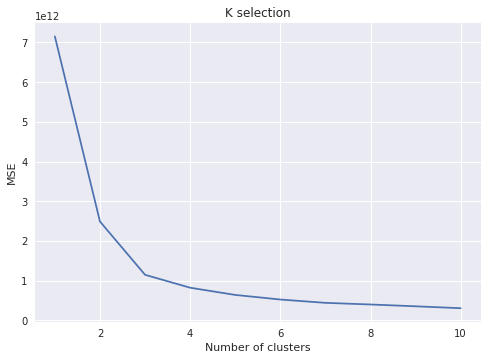

In [102]:
# Finding best k
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
#NYChouse_clustering = tony_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(NYChouse_df)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [103]:

# set the number of clusters
k = 3

# running K-Means clustering
kmeans = KMeans(n_init=400, n_clusters=k, random_state=1).fit(NYChouse_df)
kmeans.labels_

# adding the cluster labels to the dataframe
NYChouse_df.insert(0, 'Cluster', kmeans.labels_)
NYChouse_df.head()

Cluster zipcode     lat     lng  radius_in_miles  population  \
0        0   10001  40.750 -73.990         0.909091       21102   
1        0   10002  40.720 -73.990         0.795455       81410   
2        2   10003  40.730 -73.990         0.795455       56024   
3        2   10004  40.700 -74.020         1.000000        3089   
4        2   10005  40.705 -74.005         0.511364        7135   

   land_area_in_sqmi  water_area_in_sqmi  housing_units  \
0               0.62                 0.0          12476   
1               0.88                 0.0          34541   
2               0.58                 0.0          31078   
3               0.56                 0.0           2197   
4               0.07                 0.0           5317   

   occupied_housing_units  median_home_value  median_household_income  \
0                   11031           650200.0                  81671.0   
1                   32925           535600.0                  33218.0   
2                   28559           817700.0                  92540.0   
3                    1692           894200.0                 129313.0   
4                    4251          1000001.0                 124670.0   

   county_Bronx   county_Kings   county_Nassau   county_New York   \
0              0              0               0                 1   
1              0              0               0                 1   
2              0              0               0                 1   
3              0              0               0                 1   
4              0              0               0                 1   

   county_Queens   county_Richmond   
0               0                 0  
1               0                 0  
2               0                 0  
3               0                 0  
4               0                 0

In [104]:
# examining each cluster
cluster_one = NYChouse_df[NYChouse_df.Cluster == 0]
cluster_one.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_one


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Cluster zipcode    lat    lng  radius_in_miles  population  \
172        0   11385  40.70 -73.88         3.000000       98592   
166        0   11373  40.74 -73.88         0.965909      100820   
176        0   11414  40.66 -73.85         1.000000       26148   
..       ...     ...    ...    ...              ...         ...   
128        0   11219  40.63 -74.00         1.000000       92221   
8          0   10010  40.73 -73.98         1.000000       31834   
13         0   10016  40.74 -73.97         0.909091       54183   

     land_area_in_sqmi  water_area_in_sqmi  housing_units  \
172               3.61                0.03          37251   
166               1.53                0.00          33227   
176               2.30                0.09          11330   
..                 ...                 ...            ...   
128               1.48                0.00          28693   
8                 0.39                0.00          18030   
13                0.53                0.00          35617   

     occupied_housing_units  median_home_value  median_household_income  \
172                   34843           495800.0                  50799.0   
166                   31348           499600.0                  47667.0   
176                   10695           501700.0                  66790.0   
..                      ...                ...                      ...   
128                   26177           726700.0                  34316.0   
8                     16556           746200.0                  97955.0   
13                    32173           759600.0                 105324.0   

     county_Bronx   county_Kings   county_Nassau   county_New York   \
172              0              0               0                 0   
166              0              0               0                 0   
176              0              0               0                 0   
..             ...            ...             ...               ...   
128              0              1               0                 0   
8                0              0               0                 1   
13               0              0               0                 1   

     county_Queens   county_Richmond   
172               1                 0  
166               1                 0  
176               1                 0  
..              ...               ...  
128               0                 0  
8                 0                 0  
13                0                 0  

[63 rows x 18 columns]

In [105]:
cluster_two = NYChouse_df[NYChouse_df.Cluster == 1]
cluster_two.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_two

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Cluster zipcode    lat    lng  radius_in_miles  population  \
99         1   10475  40.87 -73.83              2.0       40931   
75         1   10451  40.82 -73.92              1.0       45713   
92         1   10468  40.87 -73.90              1.0       76103   
..       ...     ...    ...    ...              ...         ...   
88         1   10464  40.86 -73.79              2.0        4534   
119        1   11210  40.63 -73.95              1.0       62008   
142        1   11234  40.61 -73.89              4.0       87757   

     land_area_in_sqmi  water_area_in_sqmi  housing_units  \
99                1.72                0.10          18911   
75                1.01                0.00          17779   
92                1.08                0.02          26178   
..                 ...                 ...            ...   
88                3.50                0.09           2272   
119               1.64                0.00          22476   
142               7.55                0.83          33714   

     occupied_housing_units  median_home_value  median_household_income  \
99                    18534            76000.0                  43629.0   
75                    17106           170600.0                  26754.0   
92                    24909           171200.0                  33776.0   
..                      ...                ...                      ...   
88                     2089           484000.0                  70078.0   
119                   20653           485500.0                  55429.0   
142                   31213           488200.0                  68431.0   

     county_Bronx   county_Kings   county_Nassau   county_New York   \
99               1              0               0                 0   
75               1              0               0                 0   
92               1              0               0                 0   
..             ...            ...             ...               ...   
88               1              0               0                 0   
119              0              1               0                 0   
142              0              1               0                 0   

     county_Queens   county_Richmond   
99                0                 0  
75                0                 0  
92                0                 0  
..              ...               ...  
88                0                 0  
119               0                 0  
142               0                 0  

[91 rows x 18 columns]

In [106]:
# examining each cluster
cluster_three = NYChouse_df[NYChouse_df.Cluster == 2]
cluster_three.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_three

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Cluster zipcode     lat     lng  radius_in_miles  population  \
26        2   10029  40.790 -73.950         1.000000       76003   
16        2   10019  40.770 -73.990         0.909091       42870   
33        2   10036  40.760 -73.990         0.852273       24711   
..      ...     ...     ...     ...              ...         ...   
62        2   10282  40.716 -74.015         0.227273        4783   
6         2   10007  40.714 -74.008         0.511364        6988   
11        2   10013  40.720 -74.010         1.000000       27700   

    land_area_in_sqmi  water_area_in_sqmi  housing_units  \
26               0.83                 0.0          31121   
16               0.68                 0.0          31404   
33               0.44                 0.0          17958   
..                ...                 ...            ...   
62               0.09                 0.0           2484   
6                0.16                 0.0           3143   
11               0.55                 0.0          13460   

    occupied_housing_units  median_home_value  median_household_income  \
26                   29378           787000.0                  31888.0   
16                   25905           808600.0                  84424.0   
33                   15183           810300.0                  66599.0   
..                     ...                ...                      ...   
62                    2215          1000001.0                 230952.0   
6                     2840          1000001.0                 216037.0   
11                   12096          1000001.0                  83725.0   

    county_Bronx   county_Kings   county_Nassau   county_New York   \
26              0              0               0                 1   
16              0              0               0                 1   
33              0              0               0                 1   
..            ...            ...             ...               ...   
62              0              0               0                 1   
6               0              0               0                 1   
11              0              0               0                 1   

    county_Queens   county_Richmond   
26               0                 0  
16               0                 0  
33               0                 0  
..             ...               ...  
62               0                 0  
6                0                 0  
11               0                 0  

[24 rows x 18 columns]

In [107]:
NYCone_min = cluster_one['median_home_value'].min()
NYCone_max = cluster_one['median_home_value'].max()
NYCtwo_min = cluster_two['median_home_value'].min()
NYCtwo_max = cluster_two['median_home_value'].max()
NYCthree_min = cluster_three['median_home_value'].min()
NYCthree_max = cluster_three['median_home_value'].max()

print('The range of Cluster One is ' + str(NYCone_min) + ' - ' + str(NYCone_max))
print('The range of Cluster Two is ' + str(NYCtwo_min) + ' - ' + str(NYCtwo_max))
print('The range of Cluster Three is ' + str(NYCthree_min) + ' - ' + str(NYCthree_max))

The range of Cluster One is 495800.0 - 759600.0
The range of Cluster Two is 76000.0 - 488200.0
The range of Cluster Three is 787000.0 - 1000001.0


In [108]:
# inserting budget column into each dataframe
cluster_one.insert(0, 'Budget', 'LOW')
cluster_two.insert(0, 'Budget', 'HIGH')
cluster_three.insert(0, 'Budget', 'MEDIUM')

In [109]:
NYC_budget = pd.concat([cluster_one, cluster_two, cluster_three], ignore_index=True)
NYC_budget.head()

Budget  Cluster zipcode     lat     lng  radius_in_miles  population  \
0    LOW        0   11385  40.700 -73.880         3.000000       98592   
1    LOW        0   11373  40.740 -73.880         0.965909      100820   
2    LOW        0   11414  40.660 -73.850         1.000000       26148   
3    LOW        0   11355  40.750 -73.830         1.000000       85871   
4    LOW        0   10030  40.818 -73.943         0.568182       26999   

   land_area_in_sqmi  water_area_in_sqmi  housing_units  \
0               3.61                0.03          37251   
1               1.53                0.00          33227   
2               2.30                0.09          11330   
3               1.74                0.00          30681   
4               0.28                0.00          12976   

   occupied_housing_units  median_home_value  median_household_income  \
0                   34843           495800.0                  50799.0   
1                   31348           499600.0                  47667.0   
2                   10695           501700.0                  66790.0   
3                   28837           507500.0                  41884.0   
4                   11395           509000.0                  31925.0   

   county_Bronx   county_Kings   county_Nassau   county_New York   \
0              0              0               0                 0   
1              0              0               0                 0   
2              0              0               0                 0   
3              0              0               0                 0   
4              0              0               0                 1   

   county_Queens   county_Richmond   
0               1                 0  
1               1                 0  
2               1                 0  
3               1                 0  
4               0                 0

In [110]:
# create map
NYmap_clusters = folium.Map(location=[NYlatitude, NYlongitude], zoom_start=10, width='100%', height='100%')

# add markers to the map
for lat, lng, zipcode, budget in zip(NYC_budget['lat'], NYC_budget['lng'], NYC_budget['zipcode'], NYC_budget['Budget']):
    if budget == "LOW":
        label = folium.Popup(str(zipcode + " " + budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=6, popup=label, color='green',fill=True,fill_color='#008000',fill_opacity=2.0,parse_html=False).add_to(NYmap_clusters)
    
    elif budget == "MEDIUM":
        label = folium.Popup(str(zipcode + " " + budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=5, popup=label, color='orange',fill=True,fill_color='#FF8C00',fill_opacity=2.0,parse_html=False).add_to(NYmap_clusters)
    
    elif budget == "HIGH":
        label = folium.Popup(str(zipcode + " " + budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=5, popup=label, color='red',fill=True,fill_color='#FF6347',fill_opacity=2.0,parse_html=False).add_to(NYmap_clusters)
      
    
NYmap_clusters

In [111]:
##download TO housing Data

In [112]:
body = client_e073509e2b4e4fd9ab9d353e029fb9c7.get_object(Bucket='courseraibmcapstone-donotdelete-pr-iibp9ibtexxq7g',Key='properties.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_5 = pd.read_csv(body)

TorHouse = df_data_5
TorHouse.head()

Unnamed: 0                           Address           AreaName  Price ($)  \
0           0       86 Waterford Dr Toronto, ON           Richview     999888   
1           1  #80 - 100 BEDDOE DR Hamilton, ON     Chedoke Park B     399900   
2           2    213 Bowman Street Hamilton, ON  Ainslie Wood East     479000   
3           3      102 NEIL Avenue Hamilton, ON          Greenford     285900   
4           6   #1409 - 230 King St Toronto, ON           Downtown     362000   

         lat        lng  
0  43.679882 -79.544266  
1  43.250000 -79.904396  
2  43.251690 -79.919357  
3  43.227161 -79.767403  
4  43.651478 -79.368118

In [113]:
#drop the rows with -999 lat and lng
TorHouse = TorHouse[TorHouse.lat != -999]
TorHouse.head()

Unnamed: 0                           Address           AreaName  Price ($)  \
0           0       86 Waterford Dr Toronto, ON           Richview     999888   
1           1  #80 - 100 BEDDOE DR Hamilton, ON     Chedoke Park B     399900   
2           2    213 Bowman Street Hamilton, ON  Ainslie Wood East     479000   
3           3      102 NEIL Avenue Hamilton, ON          Greenford     285900   
4           6   #1409 - 230 King St Toronto, ON           Downtown     362000   

         lat        lng  
0  43.679882 -79.544266  
1  43.250000 -79.904396  
2  43.251690 -79.919357  
3  43.227161 -79.767403  
4  43.651478 -79.368118

In [114]:
#Use the Minimum value of $103,404 and the Maximum value of $1,360,590
TorHouse = TorHouse[TorHouse['Price ($)'] > 103404]
TorHouse = TorHouse[TorHouse['Price ($)'] < 1360590]
TorHouse.head()

Unnamed: 0                           Address           AreaName  Price ($)  \
0           0       86 Waterford Dr Toronto, ON           Richview     999888   
1           1  #80 - 100 BEDDOE DR Hamilton, ON     Chedoke Park B     399900   
2           2    213 Bowman Street Hamilton, ON  Ainslie Wood East     479000   
3           3      102 NEIL Avenue Hamilton, ON          Greenford     285900   
4           6   #1409 - 230 King St Toronto, ON           Downtown     362000   

         lat        lng  
0  43.679882 -79.544266  
1  43.250000 -79.904396  
2  43.251690 -79.919357  
3  43.227161 -79.767403  
4  43.651478 -79.368118

In [115]:
#double check the work
TorminValue = TorHouse['Price ($)'].min()
TorMaxValue = TorHouse['Price ($)'].max()
print(TorminValue)
print(TorMaxValue)

103500
1359000


In [116]:
#pull only the addresses for Toronto
TorHouse =TorHouse[TorHouse['Address'].str.contains(r'Toronto|toronto')]
TorHouse.head()

Unnamed: 0                          Address       AreaName  Price ($)  \
0            0      86 Waterford Dr Toronto, ON       Richview     999888   
4            6  #1409 - 230 King St Toronto, ON       Downtown     362000   
12          20    3 Bracebridge Ave Toronto, ON  Old East York     599900   
15          23   #710 - 1080 Bay St Toronto, ON       Downtown     805900   
17          25    160 Jenkinson Way Toronto, ON    Dorset Park     549900   

          lat        lng  
0   43.679882 -79.544266  
4   43.651478 -79.368118  
12  43.697842 -79.317368  
15  43.666794 -79.388756  
17  43.749599 -79.270844

In [117]:
#concatanate the latitude and longitudes together as coordinates to perform reverse geocoding
TorHouse['Coordinates'] = TorHouse['lat'].map(str) + ', ' + TorHouse['lng'].map(str)
#TorHouse['Coordinates'][0]
TorHouse.head()

Unnamed: 0                          Address       AreaName  Price ($)  \
0            0      86 Waterford Dr Toronto, ON       Richview     999888   
4            6  #1409 - 230 King St Toronto, ON       Downtown     362000   
12          20    3 Bracebridge Ave Toronto, ON  Old East York     599900   
15          23   #710 - 1080 Bay St Toronto, ON       Downtown     805900   
17          25    160 Jenkinson Way Toronto, ON    Dorset Park     549900   

          lat        lng                             Coordinates  
0   43.679882 -79.544266           43.679882, -79.54426600000001  
4   43.651478 -79.368118  43.651478000000004, -79.36811800000001  
12  43.697842 -79.317368                   43.697842, -79.317368  
15  43.666794 -79.388756                   43.666794, -79.388756  
17  43.749599 -79.270844          43.749598999999996, -79.270844

In [147]:
from geopy.geocoders import Nominatim
from ipykernel import kernelapp as app


In [ ]:
locator = Nominatim(user_agent='myGeocoder', timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

tqdm_notebook().pandas()

TorHouse['Address'] = TorHouse['Coordinates'].progress_apply(rgeocode)
TorHouse.head()

In [120]:
TorHouse.head()


Unnamed: 0                          Address       AreaName  Price ($)  \
0            0      86 Waterford Dr Toronto, ON       Richview     999888   
4            6  #1409 - 230 King St Toronto, ON       Downtown     362000   
12          20    3 Bracebridge Ave Toronto, ON  Old East York     599900   
15          23   #710 - 1080 Bay St Toronto, ON       Downtown     805900   
17          25    160 Jenkinson Way Toronto, ON    Dorset Park     549900   

          lat        lng                             Coordinates  
0   43.679882 -79.544266           43.679882, -79.54426600000001  
4   43.651478 -79.368118  43.651478000000004, -79.36811800000001  
12  43.697842 -79.317368                   43.697842, -79.317368  
15  43.666794 -79.388756                   43.666794, -79.388756  
17  43.749599 -79.270844          43.749598999999996, -79.270844

In [128]:
new_col_list = ['a', 'b']

TorHouse = TorHouse.join(TorHouse.Address.apply(lambda loc: pd.Series(loc, index=new_col_list)))
#if it shows only coordinates, a, and b - will need to make this a new variable/df and then join the columns together with the real
#TorHouse df with the postal codes.

TorHouse.head()

ValueError: columns overlap but no suffix specified: Index(['a', 'b'], dtype='object')

In [129]:
TorHouse.columns


Index(['Unnamed: 0', 'Address', 'AreaName', 'Price ($)', 'lat', 'lng',
       'Coordinates', 'a', 'b'],
      dtype='object')

In [130]:
new_col_list = ['PostalCode'] 
for n,col in enumerate(new_col_list):
     TorHouse[col] = TorHouse['a'].apply(lambda a: a[-15:-8])
TorHouse.head()

Unnamed: 0                          Address       AreaName  Price ($)  \
0            0      86 Waterford Dr Toronto, ON       Richview     999888   
4            6  #1409 - 230 King St Toronto, ON       Downtown     362000   
12          20    3 Bracebridge Ave Toronto, ON  Old East York     599900   
15          23   #710 - 1080 Bay St Toronto, ON       Downtown     805900   
17          25    160 Jenkinson Way Toronto, ON    Dorset Park     549900   

          lat        lng                             Coordinates  \
0   43.679882 -79.544266           43.679882, -79.54426600000001   
4   43.651478 -79.368118  43.651478000000004, -79.36811800000001   
12  43.697842 -79.317368                   43.697842, -79.317368   
15  43.666794 -79.388756                   43.666794, -79.388756   
17  43.749599 -79.270844          43.749598999999996, -79.270844   

                                  a                                b  \
0       86 Waterford Dr Toronto, ON      86 Waterford Dr Toronto, ON   
4   #1409 - 230 King St Toronto, ON  #1409 - 230 King St Toronto, ON   
12    3 Bracebridge Ave Toronto, ON    3 Bracebridge Ave Toronto, ON   
15   #710 - 1080 Bay St Toronto, ON   #710 - 1080 Bay St Toronto, ON   
17    160 Jenkinson Way Toronto, ON    160 Jenkinson Way Toronto, ON   

   PostalCode  
0      Dr Tor  
4      St Tor  
12    Ave Tor  
15     St Tor  
17    Way Tor

In [131]:
TorHouse['PostalCode'].str.contains(',')
TorHouse = TorHouse[~TorHouse.PostalCode.str.contains(', ')]
TorHouse.head(10)

Unnamed: 0                          Address       AreaName  Price ($)  \
0            0      86 Waterford Dr Toronto, ON       Richview     999888   
4            6  #1409 - 230 King St Toronto, ON       Downtown     362000   
12          20    3 Bracebridge Ave Toronto, ON  Old East York     599900   
..         ...                              ...            ...        ...   
21          29      430 Military Tr Toronto, ON    Morningside     675000   
26          34      31 Yorkshire Rd Toronto, ON        Ionview     499900   
27          35         34 Ordway Rd Toronto, ON   Kennedy Park     599000   

          lat        lng                             Coordinates  \
0   43.679882 -79.544266           43.679882, -79.54426600000001   
4   43.651478 -79.368118  43.651478000000004, -79.36811800000001   
12  43.697842 -79.317368                   43.697842, -79.317368   
..        ...        ...                                     ...   
21  43.788639 -79.207932                   43.788639, -79.207932   
26  43.740097 -79.273987                   43.740097, -79.273987   
27  43.733814 -79.250000                       43.733814, -79.25   

                                  a                                b  \
0       86 Waterford Dr Toronto, ON      86 Waterford Dr Toronto, ON   
4   #1409 - 230 King St Toronto, ON  #1409 - 230 King St Toronto, ON   
12    3 Bracebridge Ave Toronto, ON    3 Bracebridge Ave Toronto, ON   
..                              ...                              ...   
21      430 Military Tr Toronto, ON      430 Military Tr Toronto, ON   
26      31 Yorkshire Rd Toronto, ON      31 Yorkshire Rd Toronto, ON   
27         34 Ordway Rd Toronto, ON         34 Ordway Rd Toronto, ON   

   PostalCode  
0      Dr Tor  
4      St Tor  
12    Ave Tor  
..        ...  
21     Tr Tor  
26     Rd Tor  
27     Rd Tor  

[10 rows x 10 columns]

In [132]:
# one-hot encoding PostalCode

keep = TorHouse[['Price ($)', 'lat', 'lng']]
TorHouse_df = pd.concat([keep,pd.get_dummies(TorHouse['PostalCode'])], axis=1)
TorHouse_df = TorHouse_df.drop(['Ontario'], axis=1)
#TorHouse_df.columns

TorHouse_df.head(10)

KeyError: "['Ontario'] not found in axis"

In [133]:
#clustering TO Housing Data

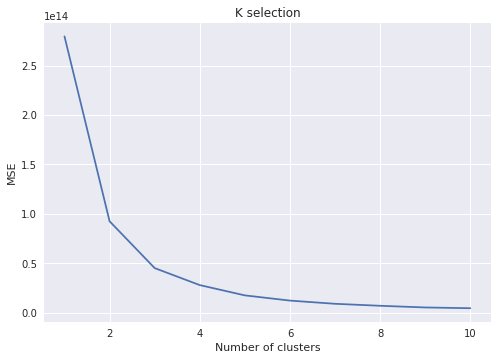

In [134]:
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(TorHouse_df)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [135]:
# set the number of clusters
k = 3

# running K-Means clustering
kmeans = KMeans(n_init=400, n_clusters=k, random_state=1).fit(TorHouse_df)
kmeans.labels_

# adding the cluster labels to the dataframe
TorHouse_df.insert(0, 'Cluster', kmeans.labels_)
TorHouse_df.head()

Cluster  Price ($)        lat        lng   AV Tor   DR Tor   Dr Tor  \
0         1     999888  43.679882 -79.544266        0        0        1   
4         0     362000  43.651478 -79.368118        0        0        0   
12        2     599900  43.697842 -79.317368        0        0        0   
15        2     805900  43.666794 -79.388756        0        0        0   
17        2     549900  43.749599 -79.270844        0        0        0   

     GA Tor   PL Tor   PT Tor  ...  kwy Tor  lvd Tor  lwy Tor  nue Tor  \
0         0        0        0  ...        0        0        0        0   
4         0        0        0  ...        0        0        0        0   
12        0        0        0  ...        0        0        0        0   
15        0        0        0  ...        0        0        0        0   
17        0        0        0  ...        0        0        0        0   

    oad Tor  res Tor  rve Tor  t W Tor  uay Tor  way Tor  
0         0        0        0        0        0        0  
4         0        0        0        0        0        0  
12        0        0        0        0        0        0  
15        0        0        0        0        0        0  
17        0        0        0        0        0        0  

[5 rows x 94 columns]

In [136]:

# examining each cluster
Tcluster_one = TorHouse_df[TorHouse_df.Cluster == 0]
Tcluster_one.sort_values("Price ($)", axis = 0, ascending = True, inplace = True) 
Tcluster_one

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Cluster  Price ($)        lat        lng   AV Tor   DR Tor   Dr Tor  \
21211        0     104900  43.749187 -79.542702        0        0        0   
20647        0     105000  43.788311 -79.268082        0        0        0   
20565        0     105000  43.640736 -79.434357        0        0        0   
...        ...        ...        ...        ...      ...      ...      ...   
17900        0     482000  43.779987 -79.412735        0        0        0   
18029        0     482500  43.667915 -79.375679        0        0        0   
2302         0     482888  43.770878 -79.411964        0        0        0   

        GA Tor   PL Tor   PT Tor  ...  kwy Tor  lvd Tor  lwy Tor  nue Tor  \
21211        0        0        0  ...        0        0        0        0   
20647        0        0        0  ...        0        0        0        0   
20565        0        0        0  ...        0        0        0        0   
...        ...      ...      ...  ...      ...      ...      ...      ...   
17900        0        0        0  ...        0        0        0        0   
18029        0        0        0  ...        0        0        0        0   
2302         0        0        0  ...        0        0        0        0   

       oad Tor  res Tor  rve Tor  t W Tor  uay Tor  way Tor  
21211        0        0        0        0        0        0  
20647        0        0        0        0        0        0  
20565        0        0        0        0        0        0  
...        ...      ...      ...      ...      ...      ...  
17900        0        0        0        0        0        0  
18029        0        0        0        0        0        0  
2302         0        0        0        0        0        0  

[2272 rows x 94 columns]

In [137]:
# examining each cluster
Tcluster_two = TorHouse_df[TorHouse_df.Cluster == 1]
Tcluster_two.sort_values("Price ($)", axis = 0, ascending = True, inplace = True) 
Tcluster_two

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Cluster  Price ($)        lat        lng   AV Tor   DR Tor   Dr Tor  \
17983        1     838000  43.670605 -79.390388        0        0        0   
1612         1     838000  43.668785 -79.384766        0        0        0   
16026        1     838888  43.781208 -79.337822        0        0        0   
...        ...        ...        ...        ...      ...      ...      ...   
1714         1    1355000  43.711609 -79.395500        0        0        0   
20978        1    1358000  43.670319 -79.394432        0        0        0   
22548        1    1358000  43.670319 -79.394432        0        0        0   

        GA Tor   PL Tor   PT Tor  ...  kwy Tor  lvd Tor  lwy Tor  nue Tor  \
17983        0        0        0  ...        0        0        0        0   
1612         0        0        0  ...        0        0        0        0   
16026        0        0        0  ...        0        0        0        0   
...        ...      ...      ...  ...      ...      ...      ...      ...   
1714         0        0        0  ...        0        0        0        0   
20978        0        0        0  ...        0        0        0        0   
22548        0        0        0  ...        0        0        0        0   

       oad Tor  res Tor  rve Tor  t W Tor  uay Tor  way Tor  
17983        0        0        0        0        0        0  
1612         0        0        0        0        0        0  
16026        0        0        0        0        0        0  
...        ...      ...      ...      ...      ...      ...  
1714         0        0        0        0        0        0  
20978        0        0        0        0        0        0  
22548        0        0        0        0        0        0  

[511 rows x 94 columns]

In [138]:
# examining each cluster
Tcluster_Three = TorHouse_df[TorHouse_df.Cluster == 2]
Tcluster_Three.sort_values("Price ($)", axis = 0, ascending = True, inplace = True) 
Tcluster_Three

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Cluster  Price ($)        lat        lng   AV Tor   DR Tor   Dr Tor  \
16665        2     484878  43.640480 -79.394966        0        0        0   
14566        2     484888  43.714592 -79.452911        0        0        0   
1587         2     484900  43.776028 -79.412056        0        0        0   
...        ...        ...        ...        ...      ...      ...      ...   
2032         2     829900  43.758427 -79.259102        0        0        0   
2461         2     830000  43.820240 -79.202942        0        0        1   
10496        2     834900  43.733833 -79.461113        0        0        0   

        GA Tor   PL Tor   PT Tor  ...  kwy Tor  lvd Tor  lwy Tor  nue Tor  \
16665        0        0        0  ...        0        0        0        0   
14566        0        0        0  ...        0        0        0        0   
1587         0        0        0  ...        0        0        0        0   
...        ...      ...      ...  ...      ...      ...      ...      ...   
2032         0        0        0  ...        0        0        0        0   
2461         0        0        0  ...        0        0        0        0   
10496        0        0        0  ...        0        0        0        0   

       oad Tor  res Tor  rve Tor  t W Tor  uay Tor  way Tor  
16665        0        0        0        0        0        0  
14566        0        0        0        0        0        0  
1587         0        0        0        0        0        0  
...        ...      ...      ...      ...      ...      ...  
2032         0        0        0        0        0        0  
2461         0        0        0        0        0        0  
10496        0        0        0        0        0        0  

[1435 rows x 94 columns]

In [139]:
TCone_min = Tcluster_one['Price ($)'].min()
TCone_max = Tcluster_one['Price ($)'].max()
TCtwo_min = Tcluster_two['Price ($)'].min()
TCtwo_max = Tcluster_two['Price ($)'].max()
TCthree_min = Tcluster_Three['Price ($)'].min()
TCthree_max = Tcluster_Three['Price ($)'].max()

print('The range of Cluster One is ' + str(TCone_min) + ' - ' + str(TCone_max))
print('The range of Cluster Two is ' + str(TCtwo_min) + ' - ' + str(TCtwo_max))
print('The range of Cluster Three is ' + str(TCthree_min) + ' - ' + str(TCthree_max))

The range of Cluster One is 104900 - 482888
The range of Cluster Two is 838000 - 1358000
The range of Cluster Three is 484878 - 834900


In [140]:
# inserting budget column into each dataframe
Tcluster_one.insert(0, 'Budget', 'MEDIUM')
Tcluster_two.insert(0, 'Budget', 'LOW')
Tcluster_Three.insert(0, 'Budget', 'HIGH')

In [141]:
# concatenating all individual cluster dataframes into a single dataframe
Tor_budget = pd.concat([Tcluster_one, Tcluster_two, Tcluster_Three], ignore_index=True)
Tor_budget.head()

Budget  Cluster  Price ($)        lat        lng   AV Tor   DR Tor  \
0  MEDIUM        0     104900  43.749187 -79.542702        0        0   
1  MEDIUM        0     105000  43.788311 -79.268082        0        0   
2  MEDIUM        0     105000  43.640736 -79.434357        0        0   
3  MEDIUM        0     105000  43.615341 -79.492996        0        0   
4  MEDIUM        0     105000  43.615341 -79.492996        0        0   

    Dr Tor   GA Tor   PL Tor  ...  kwy Tor  lvd Tor  lwy Tor  nue Tor  \
0        0        0        0  ...        0        0        0        0   
1        0        0        0  ...        0        0        0        0   
2        0        0        0  ...        0        0        0        0   
3        0        0        0  ...        0        0        0        0   
4        0        0        0  ...        0        0        0        0   

   oad Tor  res Tor  rve Tor  t W Tor  uay Tor  way Tor  
0        0        0        0        0        0        0  
1        0        0        0        0        0        0  
2        0        0        0        0        0        0  
3        0        0        0        0        0        0  
4        0        0        0        0        0        0  

[5 rows x 95 columns]

In [142]:
##cluster maps

In [ ]:
# create map
Tmap_clusters = folium.Map(location=[Tlatitude, Tlongitude], zoom_start=10, width='100%', height='100%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, budget in zip(Tor_budget['lat'], Tor_budget['lng'], Tor_budget['Budget']):
    if budget == "LOW":
        label = folium.Popup(str(budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=6, popup=label, color='green',fill=True,fill_color='#008000',fill_opacity=2.0,parse_html=False).add_to(Tmap_clusters)
    
    elif budget == "MEDIUM":
        label = folium.Popup(str(budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=5, popup=label, color='orange',fill=True,fill_color='#FF8C00',fill_opacity=2.0,parse_html=False).add_to(Tmap_clusters)
    
    elif budget == "HIGH":
        label = folium.Popup(str(budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=5, popup=label, color='red',fill=True,fill_color='#FF6347',fill_opacity=2.0,parse_html=False).add_to(Tmap_clusters)
         
Tmap_clusters

In [ ]:
##importing data from foursquare

In [ ]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'SPWJYEA3TPHEFKBZGQ2YDUE3AGFZKE21XZNA1HT215CWMAVJ

'
CLIENT_SECRET = 'OT3JSNAAREBM2H2520LYEDEW1JUNVEMDIAFQGHGMCFFCB1AE'
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    ind = 1
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        tmp=[]
        print(color.BOLD+str(ind)+" | "+name+color.END)
        ind += 1
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #tmp.append([(j['venue']['name']) for j in results])
        #for item in tmp[0]:
        #    print("\t",item)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print("\nDone!")
    return(nearby_venues)

In [ ]:
tony_venues = getNearbyVenues(names = TorNY_df['Neighborhood'],
                                   boroughs = TorNY_df['Borough'],
                                   latitudes = TorNY_df['Latitude'],
                                   longitudes = TorNY_df['Longitude']
                                  )

In [ ]:
# one hot encoding
tony_onehot = pd.get_dummies(tony_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tony_onehot['Neighborhood'] = tony_venues['Neighborhood'] 
tony_onehot['Borough'] = tony_venues['Borough']
tony_onehot['Neighborhood Latitude'] = tony_venues['Neighborhood Latitude']
tony_onehot['Neighborhood Longitude'] = tony_venues['Neighborhood Longitude']


# move neighborhood column to the first column
fixed_columns = [tony_onehot.columns[-1]] + list(tony_onehot.columns[:-1])
tony_onehot = tony_onehot[fixed_columns]

tony_grouped = tony_onehot.groupby(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

#print(tony_venues.drop_duplicates(["Neighborhood"],inplace = False)['Neighborhood'].reset_index(drop=True))    
tony_grouped

In [ ]:
#clustering 

In [ ]:
# Finding best k
plt.style.use("seaborn")
Ks = 11
mse = np.zeros((Ks-1))
tony_grouped_clustering = tony_grouped.drop(['Neighborhood','Borough','Neighborhood Latitude','Neighborhood Longitude'], 1)
for n in range(1,Ks):
    
    # set number of clusters
    kclusters = n
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    mse[n-1] = kmeans.inertia_

plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K selection")
plt.show()

In [ ]:
# set number of clusters
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(tony_grouped_clustering)
    
tony_merged = TorNY_df

# add clustering labels
tony_merged['Cluster Labels'] = kmeans.labels_

tony_merged

In [ ]:
# create map
map_clusters = folium.Map(location=[centerLatitude, centerLongitude], zoom_start=7, width='100%', height='100%')

for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    if cluster == 0:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker([lat, lon], radius=6, popup=label, color='green',fill=True,fill_color='#008000',fill_opacity=2.0,parse_html=False).add_to(map_clusters)
    
    elif cluster == 1:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker([lat, lon], radius=5, popup=label, color='blue',fill=True,fill_color='#0000FF',fill_opacity=2.0,parse_html=False).add_to(map_clusters)
    
    elif cluster == 2:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker([lat, lon], radius=5, popup=label, color='red',fill=True,fill_color='#FF6347',fill_opacity=2.0,parse_html=False).add_to(map_clusters)
         
map_clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[NYlatitude, NYlongitude], zoom_start=11, width='100%', height='100%')

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    if cluster == 0:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker([lat, lon], radius=6, popup=label, color='green',fill=True,fill_color='#008000',fill_opacity=2.0,parse_html=False).add_to(map_clusters)
    
    elif cluster == 1:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker([lat, lon], radius=5, popup=label, color='blue',fill=True,fill_color='#0000FF',fill_opacity=2.0,parse_html=False).add_to(map_clusters)
    
    elif cluster == 2:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker([lat, lon], radius=5, popup=label, color='red',fill=True,fill_color='#FF6347',fill_opacity=2.0,parse_html=False).add_to(map_clusters)
    

minimap = MiniMap(position = 'topleft', center_fixed = (NYlatitude, NYlongitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (Tlatitude, Tlongitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[Tlatitude, Tlongitude], zoom_start=11, width='100%', height='100%')

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tony_merged['Latitude'], tony_merged['Longitude'], tony_merged['Neighborhood'], tony_merged['Cluster Labels']):
    if cluster == 0:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker([lat, lon], radius=6, popup=label, color='green',fill=True,fill_color='#008000',fill_opacity=2.0,parse_html=False).add_to(map_clusters)
    
    elif cluster == 1:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker([lat, lon], radius=5, popup=label, color='blue',fill=True,fill_color='#0000FF',fill_opacity=2.0,parse_html=False).add_to(map_clusters)
    
    elif cluster == 2:
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
        folium.CircleMarker([lat, lon], radius=5, popup=label, color='red',fill=True,fill_color='#FF6347',fill_opacity=2.0,parse_html=False).add_to(map_clusters)

minimap = MiniMap(position = 'topleft', center_fixed = (NYlatitude, NYlongitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)

minimap = MiniMap(position='bottomright',  center_fixed = (Tlatitude, Tlongitude), zoom_level_fixed = 8)
minimap.add_to(map_clusters)
map_clusters

In [ ]:
#analyze Centriods


In [ ]:
cl1 = tony_merged.loc[tony_merged['Cluster Labels'] == 0, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl1

In [ ]:
cl2 = tony_merged.loc[tony_merged['Cluster Labels'] == 1, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl2

In [ ]:
pd.set_option('max_rows', 100)
cl3 = tony_merged.loc[tony_merged['Cluster Labels'] == 2, tony_merged.columns[[1] + list(range(5, tony_merged.shape[1]))]]
cl3

In [ ]:
##dataviz

In [ ]:
#np.zeros((kmeans.cluster_centers_.shape))


In [ ]:
tmp = np.zeros((kmeans.cluster_centers_.shape))
tmp[0,:] = kmeans.cluster_centers_[0,:] 
tmp[1,:] = kmeans.cluster_centers_[1,:] 
tmp[2,:] = kmeans.cluster_centers_[2,:]  

maxi = []
for i in range(3):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
  
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.transpose()

In [ ]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = 'Paired')
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster")
plt.ylabel("Frequency")

plt.show()

In [ ]:
#Show only Cluster 1 and Cluster 3, drop Cluster 2 since that's only Garden
maxi = []
for i in range(3):
    maxi.extend(tmp[i,:].argsort()[-3:][::-1])
    
args = np.asarray(list(set(maxi)))
table = pd.DataFrame(data = tmp[:,args.astype(int)], index = ['Cluster I', 'Cluster II', 'Cluster III'], columns = tony_grouped_clustering.columns[args.astype(int)])
table = table.T
table.drop(["Garden"], inplace= True)

In [ ]:
plt.style.use('seaborn')
ax = table.plot(kind='bar', figsize=(15,6), rot=90, fontsize = 14, colormap = "Paired")
bars = ax.get_children()
plt.title("Frequency of Ocurrence Within Each Cluster Without Garden!")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#overlay data clusters
from folium.plugins import MarkerCluster


In [ ]:
NYCrimeHouse = folium.Map(location=[NYlatitude, NYlongitude], zoom_start=10, width='100%', height='100%')

folium.Choropleth(
    geo_data = NYCrime_geo,
    name = 'NYC Crime Heat Map',
    data = NY_crime,
    columns = ['Precinct Number', 'Number'],
    key_on = 'feature.properties.Precinct',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Crimes in New York City - Manhattan'
).add_to(NYCrimeHouse)

# add markers to the map
for lat, lng, zipcode, budget in zip(NYC_budget['lat'], NYC_budget['lng'], NYC_budget['zipcode'], NYC_budget['Budget']):
    if budget == "LOW":
        label = folium.Popup(str(zipcode + " " + budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=4, popup=label, color='green',fill=True,fill_color='#008000',fill_opacity=2.0,parse_html=False).add_to(NYCrimeHouse)
        
    elif budget == "MEDIUM":
        label = folium.Popup(str(zipcode + " " + budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=3, popup=label, color='orange',fill=True,fill_color='#FF8C00',fill_opacity=2.0,parse_html=False).add_to(NYCrimeHouse)
    
    elif budget == "HIGH":
        label = folium.Popup(str(zipcode + " " + budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=3, popup=label, color='red',fill=True,fill_color='#FF6347',fill_opacity=2.0,parse_html=False).add_to(NYCrimeHouse)

folium.LayerControl().add_to(NYCrimeHouse)

NYCrimeHouse

In [ ]:
TorCrimeHouse = folium.Map(location=[Tlatitude, Tlongitude], zoom_start=10, width='100%', height='100%')

folium.Choropleth(
    geo_data =Tor_geo,
    data = Tor_crime,
    columns = ['Neighbourhood','Number'],
    key_on ='feature.properties.AREA_NAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Crimes in Toronto"
).add_to(TorCrimeHouse)

#map the housing cluster map
for lat, lng, budget in zip(Tor_budget['lat'], Tor_budget['lng'], Tor_budget['Budget']):
    if budget == "LOW":
        label = folium.Popup(str(budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=3, popup=label, color='green',fill=True,fill_color='#008000',fill_opacity=2.0,parse_html=False).add_to(TorCrimeHouse)
    
    elif budget == "MEDIUM":
        label = folium.Popup(str(budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=2, popup=label, color='orange',fill=True,fill_color='#FF8C00',fill_opacity=2.0,parse_html=False).add_to(TorCrimeHouse)
    
    elif budget == "HIGH":
        label = folium.Popup(str(budget), parse_html=True)
        folium.CircleMarker([lat, lng], radius=2, popup=label, color='red',fill=True,fill_color='#FF6347',fill_opacity=2.0,parse_html=False).add_to(TorCrimeHouse)        
        
        
folium.LayerControl().add_to(TorCrimeHouse)

TorCrimeHouse